# Régression linéaire sur les notes des applications mobiles

## Objectif

L'objectif de cet exercice est de prédire l'évaluation des applications mobiles de Google Play Store avec un jeu de 
données disponible sur Kaggle : https://www.kaggle.com/lava18/google-play-store-apps

## Pré-traitement et visualisation

Le pré-traitement dans ce jeu de données consiste à retirer les valeurs manquantes, transformer les catégories en 
valeurs binaires, reformater les entiers sous la forme 1M en 1000000.

Afin de sélectionner les attributs pour notre régression linéaire finale, nous allons étudier l'impact de chaque 
attribut de manière individuelle.


In [1]:
from builtins import float, int

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("googleplaystore.csv")
print(df.shape)
df.head()


(10841, 13)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
df.dropna(inplace = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


count    9360.000000
mean        4.191838
std         0.515263
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

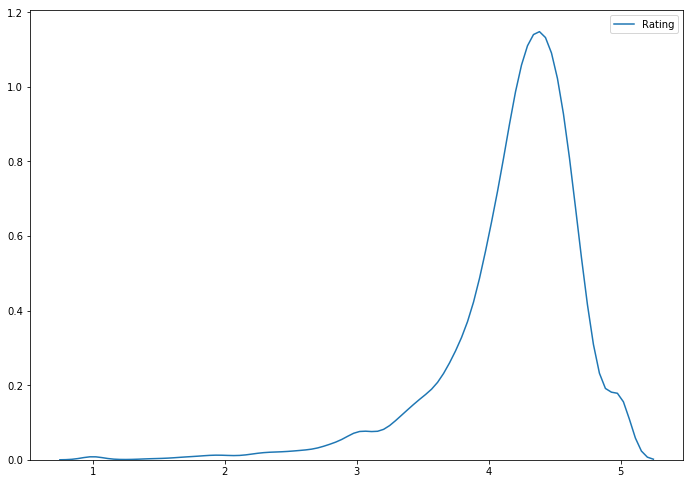

In [4]:
rcParams['figure.figsize'] = 11.7, 8.27
sns.kdeplot(df.Rating)
df.Rating.describe()


### Catégorie


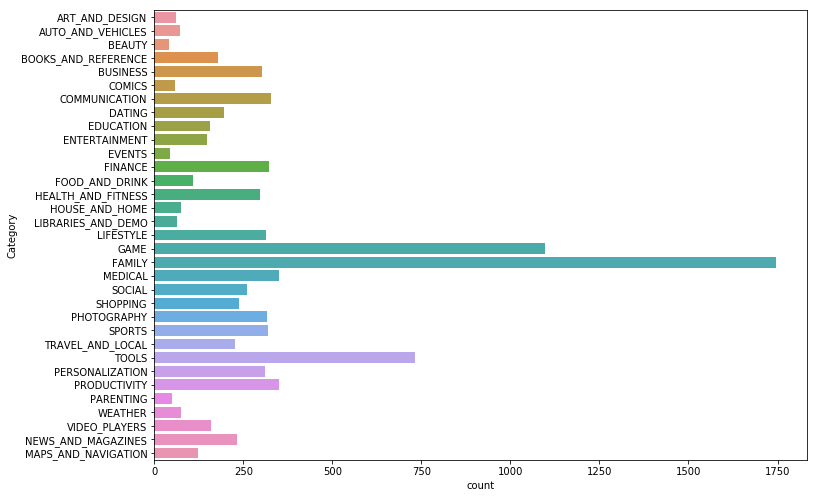

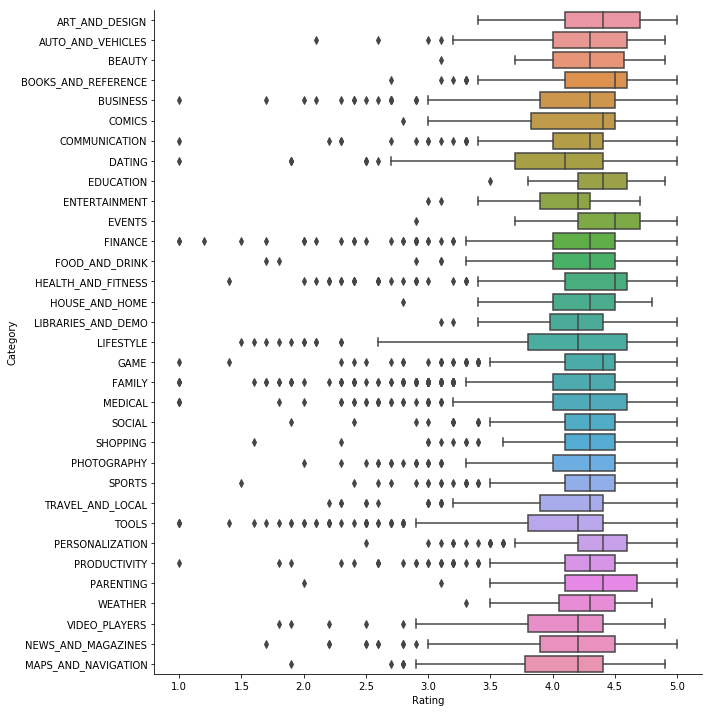

In [5]:
sns.countplot(y=df.Category)
sns.catplot(y="Category", x="Rating", data=df, kind="box", height=10)



Les applications sont réparties de manière non uniforme, la notation dépend légèrement de la catégorie.

---

### Évaluation


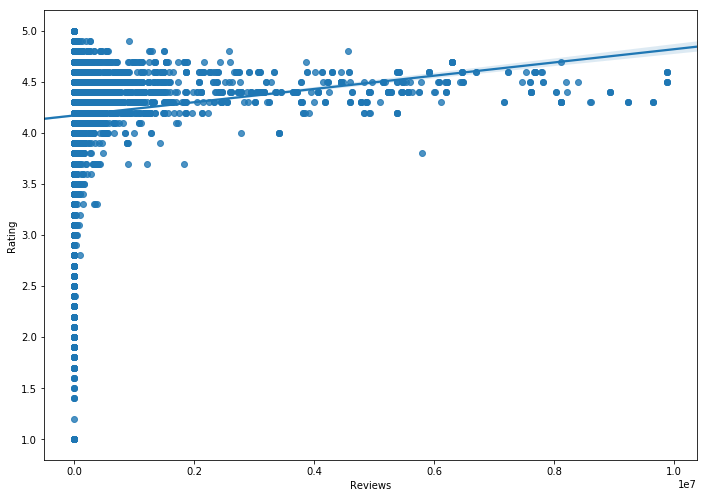

In [6]:
df.Reviews = df.Reviews.astype(float)
sns.regplot(x="Reviews", y="Rating", data=df[df.Reviews<1e7]);


Les applications ayant le plus d'évaluations ont tendance à avoir une meilleur note.

Note : seuls les applications ayant moins de 10M d'évaluations sont affichées dû au nombre très faible des exemples 
avec plus de 10M évaluations. (Facebook, Instagram, Wechat..)

---

### Taille de l'application


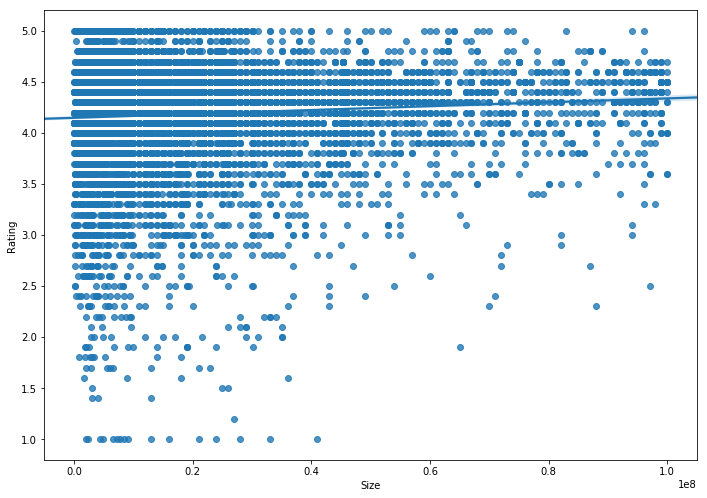

In [7]:
df.Size.replace('Varies with device', np.nan, inplace=True)

df.Size = df.Size.str.replace('+','')
df.Size = df.Size.str.replace(',','')

df.Size = (df.Size.replace(r'[kM]+$', '', regex=True).astype(float) * 
          df.Size.str.extract(r'[\d\.]+([kM]+)', expand=False).fillna(1).replace(['k','M'], [10**3, 10**6]).astype(int))

df.Size.fillna(df.groupby('Category')['Size'].transform('mean'), inplace=True)

sns.regplot(x="Size", y="Rating", data=df);


Il existe une légère corrélation entre la taille de l'application et sa note, on ne peut pas déduire d'explications, 
les applications volumineuses peuvent contenir plus d'images, d'animations ou bien de fonctionnalités.

---

### Nombre d'installations

Note : les données sont sous la forme '1+', '5+', '10+', qui peut induire une importante imprécision dû aux 
intervalles très grands.


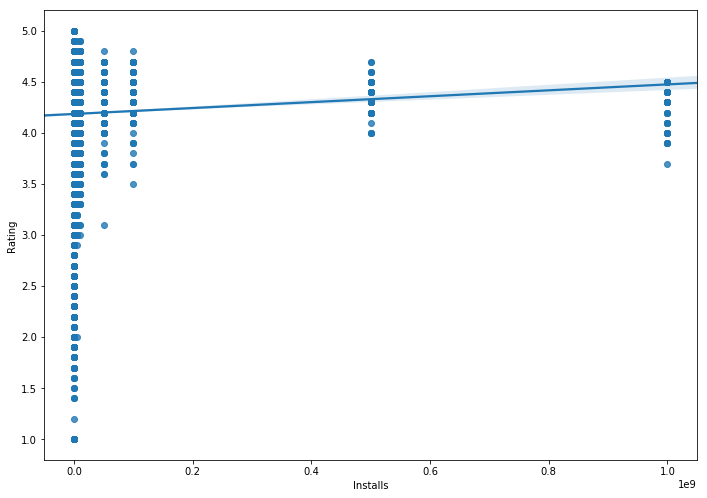

In [8]:
df.Installs = df.Installs.str.replace('+','')
df.Installs = df.Installs.str.replace(',','')
df.Installs = df.Installs.astype(int)

sns.regplot(x="Installs", y="Rating", data=df);


Les applications les plus installées sont les mieux notées, l'implication inverse peut être vraie : une application 
mieux notée a plus de chance d'être installée.

---

### Type



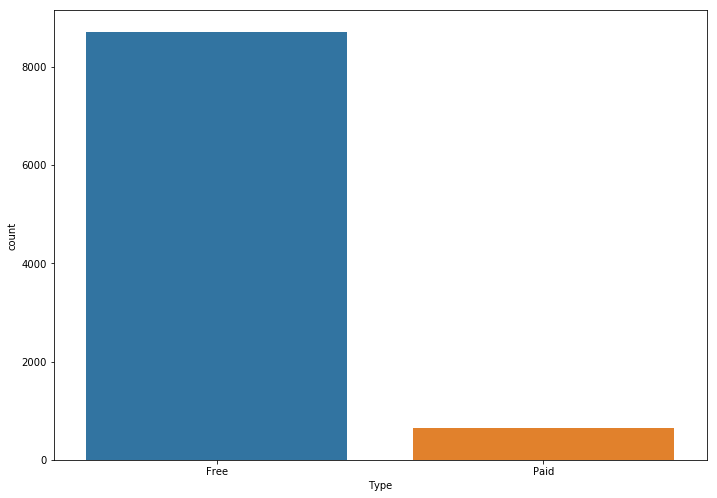

In [9]:
sns.countplot(x="Type", data=df)

df.Price = df.Price.str.replace('$','')
df.Price = df.Price.astype(float)


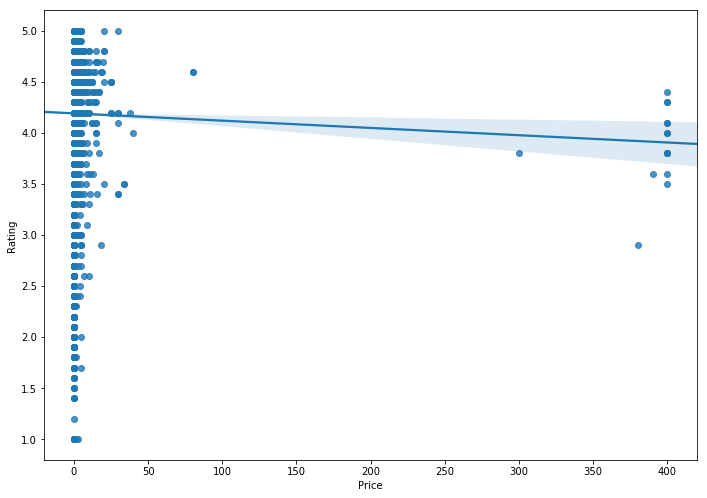

In [10]:
sns.regplot(x="Price", y="Rating", data=df);


Les applications payantes représentent un faible pourcentage des applications sur le Play Store, il est nécessaire d'en 
tenir compte dans la régression linéaire basée sur le prix.

---

### Contenu


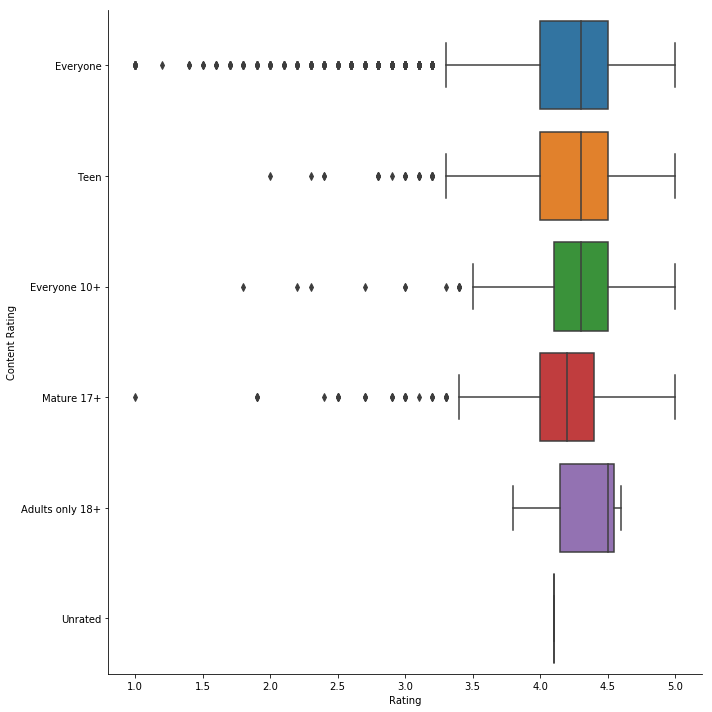

In [11]:
sns.catplot(y="Content Rating", x="Rating", data=df, kind="box", height=10)


La note dépend faiblement du type de contenu, bien que le contenu pour adulte obtient de meilleures notes.

---

### Genre


array(['Art & Design', 'Art & Design;Pretend Play',
       'Art & Design;Creativity', 'Auto & Vehicles', 'Beauty',
       'Books & Reference', 'Business', 'Comics', 'Comics;Creativity',
       'Communication', 'Dating', 'Education;Education', 'Education',
       'Education;Creativity', 'Education;Music & Video',
       'Education;Action & Adventure', 'Education;Pretend Play',
       'Education;Brain Games', 'Entertainment',
       'Entertainment;Music & Video', 'Entertainment;Brain Games',
       'Entertainment;Creativity', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Lifestyle;Pretend Play',
       'Adventure;Action & Adventure', 'Arcade', 'Casual', 'Card',
       'Casual;Pretend Play', 'Action', 'Strategy', 'Puzzle', 'Sports',
       'Music', 'Word', 'Racing', 'Casual;Creativity',
       'Casual;Action & Adventure', 'Simulation', 'Adventure', 'Board',
       'Trivia', 'Role Playing', 'Simulation;Education',
 

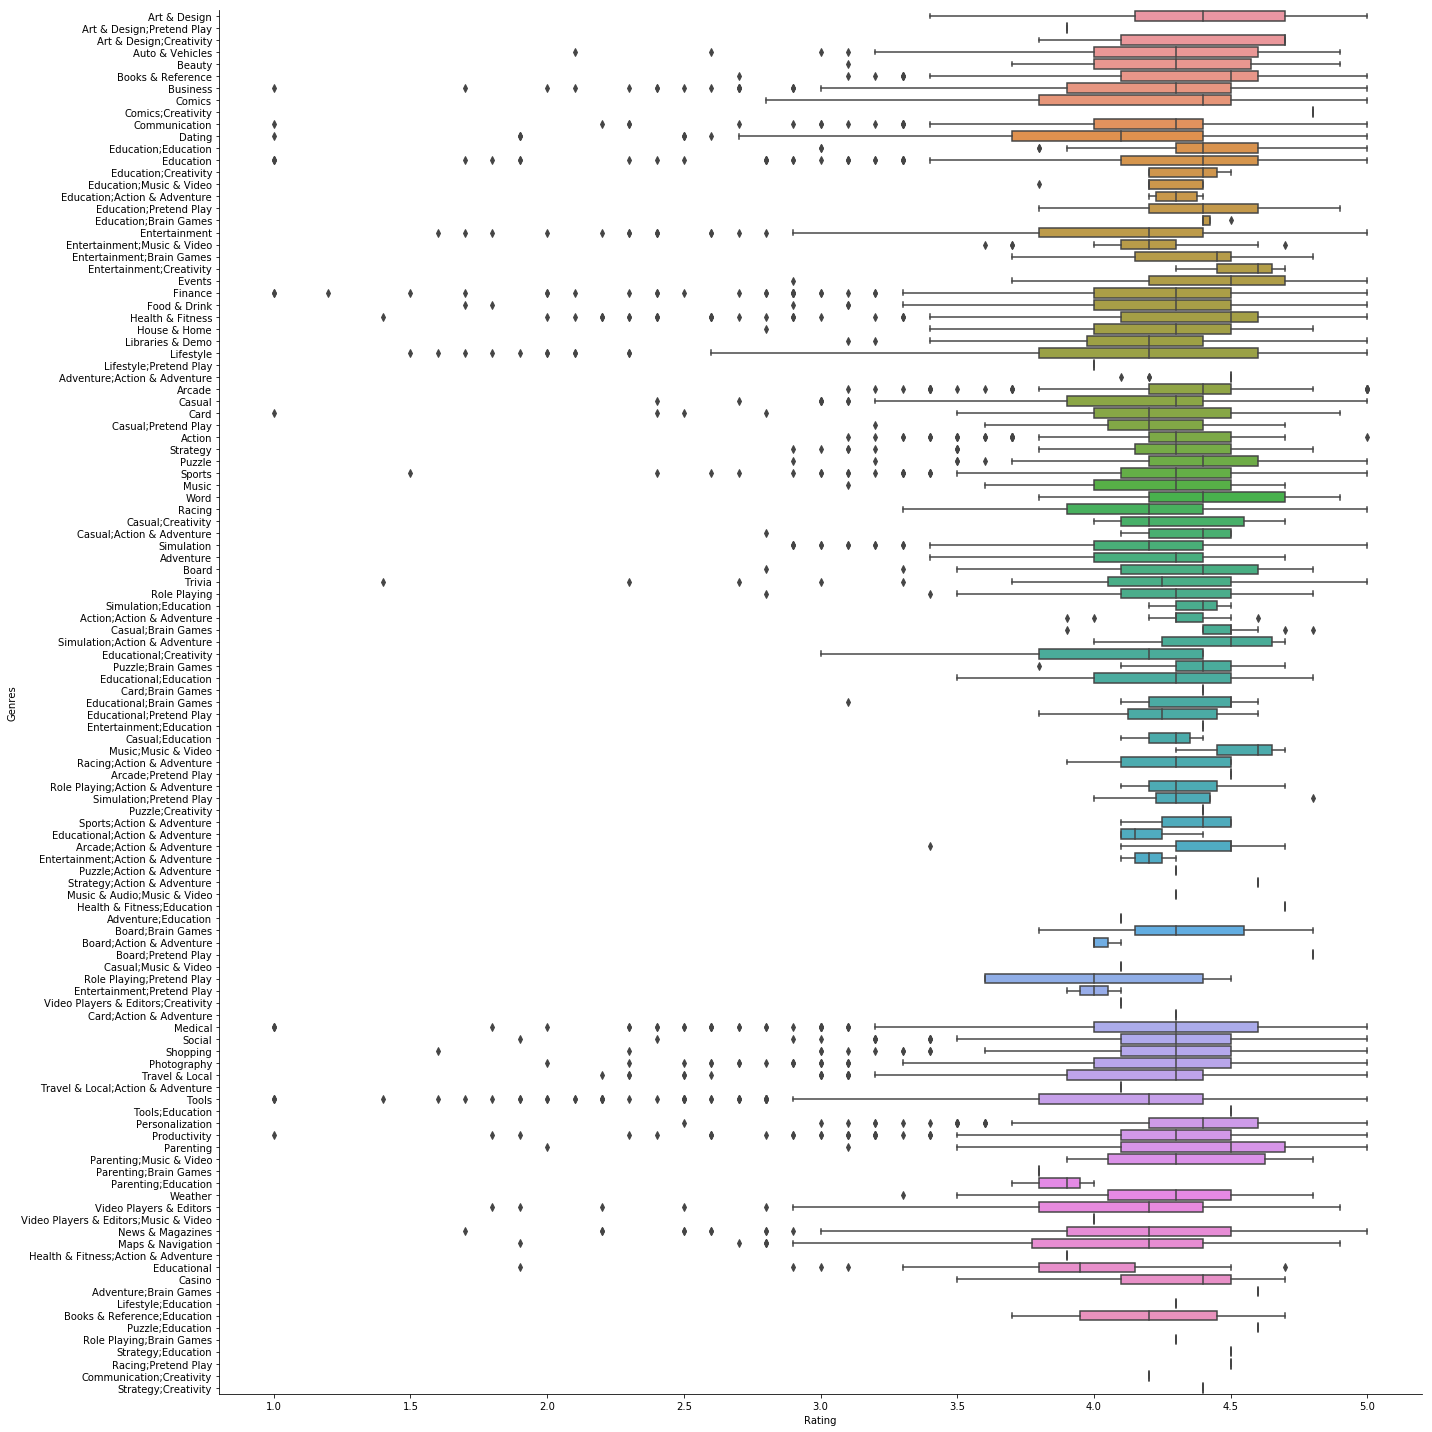

In [12]:
sns.catplot(y="Genres", x="Rating", data=df, kind="box", height=20)
df.Genres.unique()


Il existe un nombre élevé de sous catégories, étant donné leur non-uniformité, il n'est pas assez intéressant de les 
regrouper ou de convertir en valeurs binaires.

---

### Date de dernière mise à jour


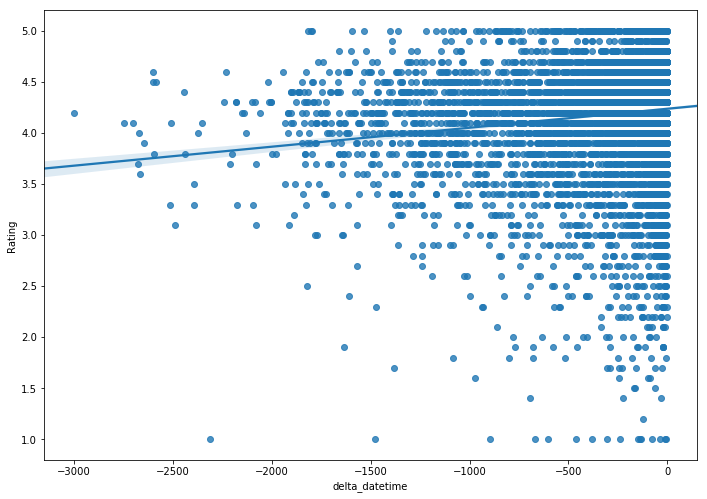

In [13]:
df['Datetime'] = df['Last Updated'].apply(lambda x: pd.to_datetime(x))
last_date = df.Datetime.max()
df['delta_datetime'] = (df.Datetime - last_date).dt.days
sns.regplot(x="delta_datetime", y="Rating",data=df);


La date de dernière mise-à-jour n'apporte aucune information en l'état, nous allons donc créer un attribut qui modélise 
le nombre de jours avant la dernière date. Une application mise à jour le jour de la création du jeu de données aura 
comme valeur 0 alors qu'une application mise à jour il y a 20 jours aura comme valeur -20.

On observe qu'une application mise à jour régulièrement obtient une note élevée. Cette observation paraît logique, 
une application à jour contient généralement moins de bugs et plus de fonctionnalités.

---

In [14]:
df.head()


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Datetime,delta_datetime
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19000000.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,2018-01-07,-213
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14000000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,2018-01-15,-205
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8700000.0,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,2018-08-01,-7
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25000000.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,2018-06-08,-61
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2800000.0,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,2018-06-20,-49



## Sélection des attributs

Pour la régression linéaire, seuls les attributs numériques sont sélectionnés, les attributs 'Type', 'Content Rating', 
'Genres', 'Last Updated', 'Current Ver' et 'Android Ver' se seront pas pris en compte car ils étaient moins 
pertinents. Les catégories ont été converties en valeurs binaires, par exemple, une application de catégorie 
'ART_AND_DESIGN' aura comme valeur 1 pour l'attribut 'Category_ART_AND_DESIGN'


In [15]:
df_binary_cat = pd.get_dummies(df, columns=['Category'])
df_binary_cat.head()


,App,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159.0,19000000.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",...,0,0,0,0,0,0,0,0,0,0
1,Coloring book moana,3.9,967.0,14000000.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",...,0,0,0,0,0,0,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510.0,8700000.0,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",...,0,0,0,0,0,0,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644.0,25000000.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",...,0,0,0,0,0,0,0,0,0,0
4,Pixel Draw - Number Art Coloring Book,4.3,967.0,2800000.0,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_numerical = df_binary_cat.drop(columns=['App', 'Type', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 
                                   'Android Ver', 'Datetime'])
df_numerical.head()


,Rating,Reviews,Size,Installs,Price,delta_datetime,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,4.1,159.0,19000000.0,10000,0.0,-213,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967.0,14000000.0,500000,0.0,-205,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510.0,8700000.0,5000000,0.0,-7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644.0,25000000.0,50000000,0.0,-61,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967.0,2800000.0,100000,0.0,-49,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0



## Régression Linéaire

Dans un premier temps, le jeu de données sera divisé en TRAIN et TEST avec une taille de 20% pour le test.
La régression linéaire sera entraînée sur TRAIN et l'erreur sera calculée sur l'ensemble TEST.


In [17]:
y = df_numerical.Rating
X = df_numerical.drop(columns=['Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
model = LinearRegression()
model.fit(X_train, y_train)

results = model.predict(X_test)


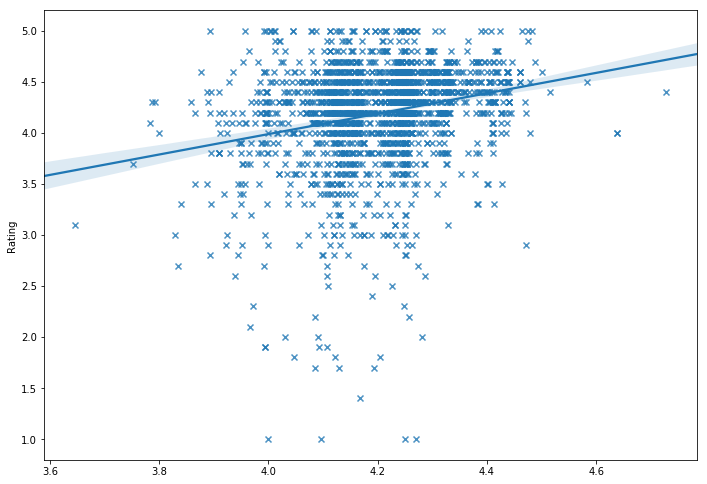

In [18]:
sns.regplot(results, y_test, marker = 'x')


In [19]:
print("Mean squared error: %.3f" % mean_squared_error(y_test, results))
print('Variance score: %.3f' % r2_score(y_test, results))


Mean squared error: 0.247
Variance score: 0.055



## Résultats

Notre régression linéaire parvient à capturer de l'information dans les attributs donnés mais sans surprise, le R² 
score est très mauvais (loin de 1).

La moyenne des erreurs au carré est de 0.25, ce qui est acceptable dans le cadre de la notation des applications allant 
de 1 à 5.

Le mauvais R² score peut s'expliquer par la forte indépendance entre les attributs et la note, une application souvent 
installée peut avoir une bonne comme une mauvaise note (application installée par défaut, monopole).
Les applications ayant eu une mise-à-jour récente peuvent apporter d'autres bugs ou fonctionnalités inutiles.
Le nombre d'évaluations n'est pas non plus significatif, un utilisateur très mécontent sera motivé à laisser un avis 
négatif (ou signaler les bugs) alors qu'un utilisateur content ne pensera pas forcément à laisser un avis. 
(Remarque basée sur des faits personnels)

---

Une amélioration majeure qui peut être apportée serait d'étudier les avis écrits en profondeur 
(NLP, sentiment analysis) qui sont bien plus significatifs dans l'explication de la note. De manière basique, le 
vocabulaire utilisé peut être converti en valeurs numériques, les avis contenant un ou plusieurs mots mélioratifs aura 
tendance à impliquer une meilleure note et inversement.